In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from context_analysis.load import load_spikes, load_cells
from context_analysis.onep.reshape import pivot
from context_analysis.onep.preprocessing import (
    get_pivoted_X, block_from_time, remove_mixed_ys, remove_nan_ys, get_block_index, bin_blocks
)
from context_analysis.utils import get_derived_data_dir
from spiketimes.df.statistics import ifr_by
import pyarrow.feather as feather
import matplotlib.pyplot as plt

In [2]:
def preprocess_spikes(spikes, session_name, *, time_col="time", value_col="value", block_length=120, num_block_segments=None, max_block_idx=None):
    spikes["spiketimes"] = (spikes[value_col] > 0).astype(np.int)
    spikes["block"] = block_from_time(spikes, session_name=session_name)
    spikes["block_idx"] = get_block_index(spikes[time_col])
    if max_block_idx is not None:
        spikes = spikes.loc[spikes["block_idx"] <= max_block_idx]
    if num_block_segments is not None:
        spikes = spikes.copy()
        spikes["block_segment"] = bin_blocks(spikes[time_col].values, block_length=block_length, num_parts=num_block_segments)
    return spikes

def get_spikecounts_by_blockidx(
    spikes: pd.DataFrame, *, spiketimes_col="spiketimes", cell_col= "cell_id", 
    block_col="block", block_idx_col="block_idx",
    block_segment_col=None
) -> pd.DataFrame:
    grouping_cols = [cell_col, block_col, block_idx_col]
    if block_segment_col is not None:
        grouping_cols = grouping_cols + [block_segment_col]
    spikes = spikes.groupby(grouping_cols, as_index=False)
    spikes = spikes["spiketimes"].apply(np.sum)
    return spikes

def get_group(spikes: pd.DataFrame, cells: pd.DataFrame, *, cell_col="cell_id", group_col="group") -> pd.DataFrame:
    spikes = spikes.merge(cells[[cell_col, group_col]]).drop_duplicates()
    return spikes

def exclude_inactive_cells(
    spikes, *, min_active_segments=None, min_spike_max=None, cell_col="cell_id", spike_count_col="spiketimes"
) -> pd.DataFrame:
    if min_active_segments is not None:
        spikes = spikes.groupby(cell_col).filter(lambda x: (x[spike_count_col] > 0).sum() > min_active_segments)
    if min_spike_max is not None:
        spikes = spikes.groupby(cell_col).filter(lambda x: x[spike_count_col].max() > min_spike_max)
    return spikes

In [3]:
data_dir = get_derived_data_dir(experiment="pfc")
cells = load_cells(experiment="pfc")

# binning rules
NUM_BLOCK_SEGMENTS =3

# exclusion criteria
MIN_ACTIVE_SEGMENTS = 5
MIN_SPIKE_MAX = 2

In [4]:
session_name = "day4-test1"
spikes = load_spikes("pfc", session_names=[session_name])
spikes = preprocess_spikes(spikes, session_name=session_name, num_block_segments=NUM_BLOCK_SEGMENTS, max_block_idx=5)
spikes_by_segment_test1 = get_spikecounts_by_blockidx(spikes, block_segment_col="block_segment")
spikes_by_segment_test1= get_group(spikes_by_segment_test1, cells)
spikes_by_segment_test1 = exclude_inactive_cells(
    spikes_by_segment_test1, min_active_segments=MIN_ACTIVE_SEGMENTS, min_spike_max=MIN_SPIKE_MAX
)
spikes_by_segment_test1["session_name"] = session_name

In [5]:
session_name = "day5-test2"
spikes = load_spikes("pfc", session_names=[session_name])
spikes = preprocess_spikes(spikes, session_name=session_name, num_block_segments=NUM_BLOCK_SEGMENTS, max_block_idx=5)
spikes_by_segment_test2 = get_spikecounts_by_blockidx(spikes, block_segment_col="block_segment")
spikes_by_segment_test2= get_group(spikes_by_segment_test2, cells)
spikes_by_segment_test2 = exclude_inactive_cells(
    spikes_by_segment_test2, min_active_segments=MIN_ACTIVE_SEGMENTS, min_spike_max=MIN_SPIKE_MAX
)
spikes_by_segment_test2["session_name"] = session_name

In [6]:
res = pd.concat([spikes_by_segment_test1, spikes_by_segment_test2])

In [8]:
# to R for mixed modelling 
feather.write_feather(res, str(data_dir / "spikes_by_block.f"))

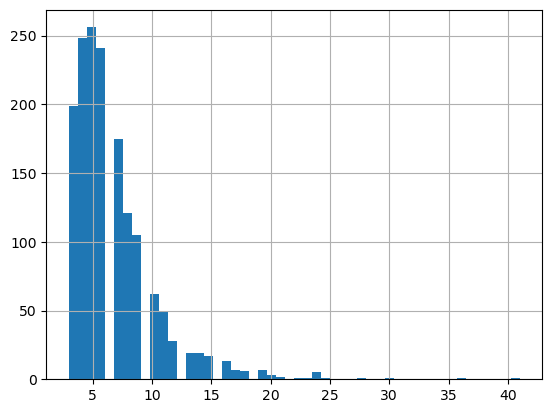

In [9]:
res.groupby("cell_id")["spiketimes"].max().hist(bins=50)
plt.show()

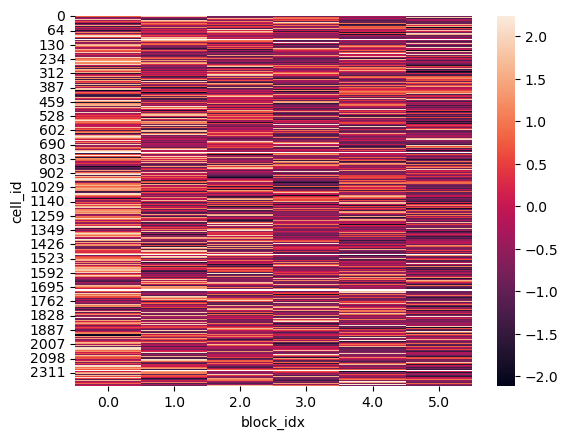

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
df1 = spikes_by_block_test1.loc[lambda x: x.group == "Experimental"]

dfp = df1.pivot(index="block_idx", columns="cell_id", values="spiketimes")
dfp = dfp.apply(zscore).transpose()
sns.heatmap(dfp)
plt.show()

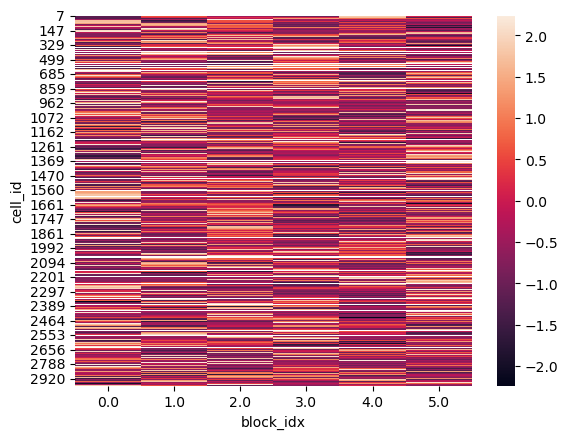

In [128]:
df1 = spikes_by_block_test1.loc[lambda x: x.group == "One Context"]

dfp = df1.pivot(index="block_idx", columns="cell_id", values="spiketimes")
dfp = dfp.apply(zscore).transpose()
sns.heatmap(dfp)
plt.show()

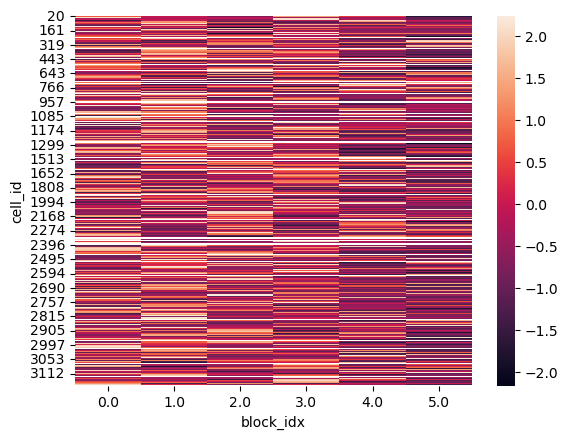

In [129]:
df1 = spikes_by_block_test1.loc[lambda x: x.group == "No Shock"]

dfp = df1.pivot(index="block_idx", columns="cell_id", values="spiketimes")
dfp = dfp.apply(zscore).transpose()
sns.heatmap(dfp)
plt.show()